In [75]:
library(splatter)

library(scater)
library(Seurat)
library(dplyr)
library(Matrix)
# library(clues)
# library(SC3)
library(SingleCellExperiment)
library(harmony)
library(FNN)
library(flexclust)
library(stats)
dirs="/data02/tguo/space_batch_effect/simulate/"

模拟转录组

In [101]:
batch_sim1=1
types='_types6'
batch_sim=paste("_",batch_sim1,sep="")
N_gene=500
N_cell=c(500,500)
seed=1234
#作为base, 每个gene的分布
base_mean_rate=15
base_mean_shape=0.1
#每个cell的library size
cell_reads_num=10
cell_reads_var=0.1
##batch 
batch_loc=c(0,batch_sim1)
batch_scale=c(1,1)
#每个细胞类型的细胞数量所占的比例
# cell_type_prob=c(0.15,0.15,0.2,0.2,0.14,0.16)
cell_type_prob=c(0.15,0.15,0.15,0.2,0.2,0.15)
#每个细胞类型相对于base发生差异表达的基因的比例，用来衡量两个type的差异
gene_diff_prob=c(0.01,0.01,0.7,0.8,0.6,0.9)
gene_down_prob=c(0.1,0.1,0.1,0.1,0.1,0.1)
gene_diff_loc=c(1,1,10,15,15,15)
# gene_diff_scale=c(1,1,1,1,1,1)
gene_diff_scale=c(1,1,1,1,1,1)
#发生drop out的概率
drop_mid=c(0,1)
drop_shape=c(-5,-5)
#极端高表达的gene所占的比例
outlier=0.0001
params <- newSplatParams()
params<- setParams(params,update=list(nGenes = N_gene, mean.rate = base_mean_rate, mean.shape=base_mean_shape,out.prob=outlier,
                                      batchCells = N_cell,lib.loc=cell_reads_num, lib.scale=cell_reads_var, lib.norm=FALSE, 
                                      batch.facLoc=batch_loc,batch.facScale=batch_scale,group.prob=cell_type_prob,
                                      de.prob=gene_diff_prob, de.facLoc=gene_diff_loc,de.facScale=gene_diff_scale, 
                                      dropout.type="experiment", dropout.mid=drop_mid, dropout.shape=drop_shape,seed=seed))
sim<-splatSimulate(params, verbose = FALSE, method="groups")
sim<-logNormCounts(sim)
mat=sim@assays@data$logcounts
group<-sim$Group
batch<-sim$Batch
meta=data.frame(celltype=group,batch=batch)
rownames(meta)<-colnames(mat)
# cc1=c('Group1','Group2','Group3','Group4','Group5')
# cc2=c('Group6','Group1','Group2','Group3','Group4')
# id1=intersect(which(meta$celltype%in%cc1),which(meta$batch=='Batch1'))
# id2=intersect(which(meta$celltype%in%cc2),which(meta$batch=='Batch2'))
# mat=mat[,c(id1,id2)]
# meta=meta[c(id1,id2),]
# writeMM(mat,paste(dirs,"origin/mat",batch_sim,types,".mtx",sep=""))
# write.table(rownames(mat),paste(dirs,"origin/mat_rownames",batch_sim,types,".txt",sep=""),col.names=F,row.names=F,quote=F)
# write.table(colnames(mat),paste(dirs,"origin/mat_colnames",batch_sim,types,".txt",sep=""),col.names=F,row.names=F,quote=F)
# write.table(meta,paste(dirs,"origin/meta",batch_sim,types,".txt",sep=""),col.names=T,row.names=T,sep=',',quote=F)


#########################
obj2<-CreateSeuratObject(counts=mat,meta.data=meta)
VariableFeatures(obj2)<-rownames(mat)
obj2@assays$RNA@scale.data=as.matrix(mat)
obj2<-RunPCA(obj2,npcs=30,verbose=F)
obj2<-RunUMAP(obj2,reduction='pca',dims=1:30,verbose=F)
# obj2<-FindNeighbors(obj2,dims=1:30)
# obj2<-FindClusters(obj2,resolution=0.4)
DimPlot(obj2,group.by='celltype',label=T)
DimPlot(obj2,group.by='batch',label=T)
# ub=unique(meta$batch)
# id=(meta$batch==ub[1])
# obj1<-CreateSeuratObject(counts=mat[,id],meta.data=meta[id,])
# VariableFeatures(obj1)<-rownames(mat[,id])
# obj1@assays$RNA@scale.data=as.matrix(mat[,id])
# obj1<-RunPCA(obj1,npcs=30,verbose=F)
# obj1<-RunUMAP(obj1,reduction='pca',dims=1:30,verbose=F)
# id=(meta$batch==ub[2])
# obj2<-CreateSeuratObject(counts=mat[,id],meta.data=meta[id,])
# VariableFeatures(obj2)<-rownames(mat[,id])
# obj2@assays$RNA@scale.data=as.matrix(mat[,id])
# obj2<-RunPCA(obj2,npcs=30,verbose=F)
# obj2<-RunUMAP(obj2,reduction='pca',dims=1:30,verbose=F)
# DimPlot(obj1,group.by='celltype',label=T)
# DimPlot(obj1,group.by='batch',label=T)
# DimPlot(obj2,group.by='celltype',label=T)
# DimPlot(obj2,group.by='batch',label=T)


ERROR: Error in splatSimDropout(sim, params): dropout.type is set to 'experiment' but dropout.mid and dropout.shape aren't length 1


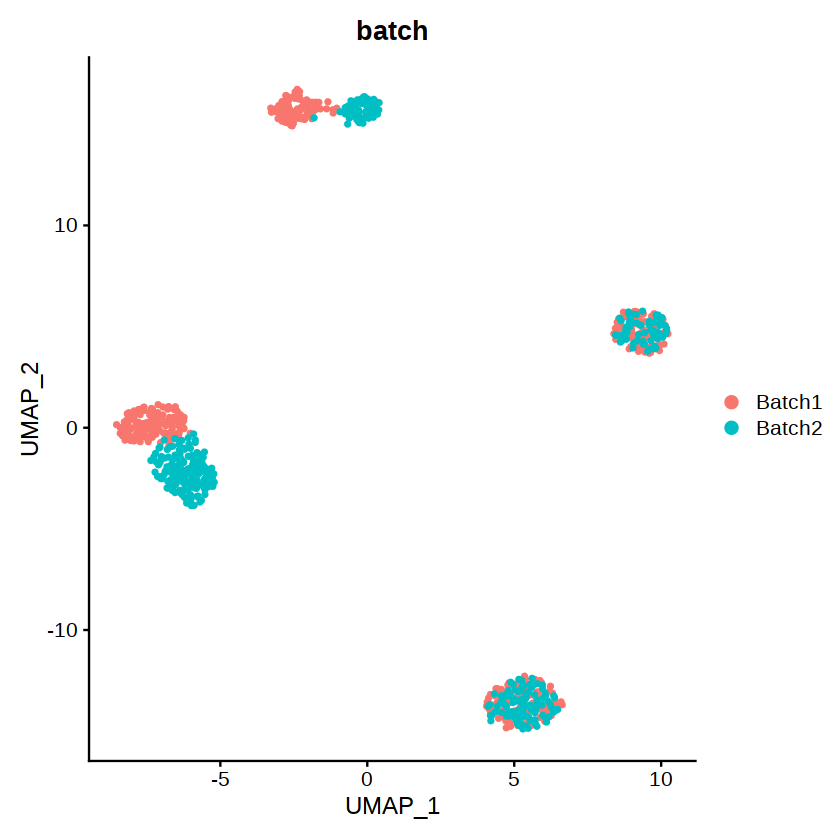

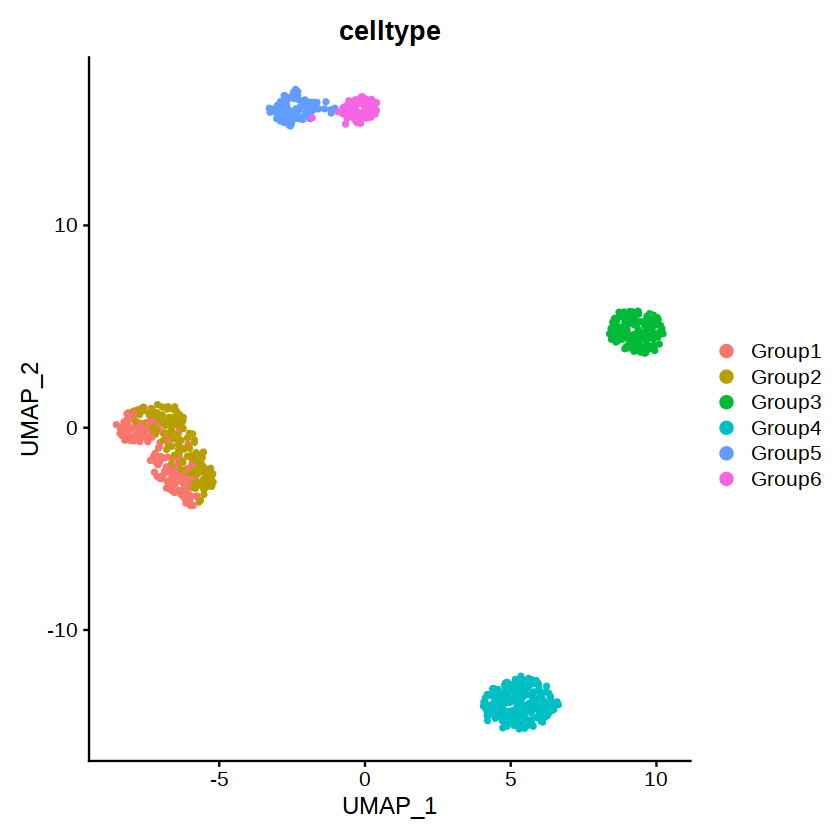

In [4]:
batch_sim="_1"
types="_types5"
mat=readMM(paste(dirs,"origin/mat",batch_sim,types,".mtx",sep=""))
colnames(mat)=read.table(paste(dirs,"origin/mat_colnames",batch_sim,types,".txt",sep=""))[,1]
rownames(mat)=read.table(paste(dirs,"origin/mat_rownames",batch_sim,types,".txt",sep=""))[,1]
meta=read.table(paste(dirs,"origin/meta",batch_sim,types,".txt",sep=""),header=T,row.names=1,stringsAsFactors=F,sep=',')
mat=as(mat,'dgCMatrix')
#####seurat#######
obj<-CreateSeuratObject(counts=mat,meta.data=meta)
VariableFeatures(obj)<-rownames(mat)
obj.list<-SplitObject(obj,split.by="batch")
obj.anchors<-FindIntegrationAnchors(obj.list, dims = 1:30,k.anchor =5,verbose=F)
obj.inte<-IntegrateData(anchorset=obj.anchors,dims=1:30,verbose=F,k.weight=100)
# obj.inte<-ScaleData(obj.inte,verbose=F)
obj.inte@assays$integrated@scale.data=as.matrix(obj.inte@assays$integrated@data)
obj.inte<-RunPCA(obj.inte,npcs=30,verbose=F)
obj.inte<-RunUMAP(obj.inte,reduction="pca",dims=1:30,verbose=F)
DimPlot(obj.inte,group.by="batch")
DimPlot(obj.inte,group.by="celltype")
a=as.data.frame(obj.inte@reductions$pca@cell.embeddings)
a=a[rownames(meta),]
write.csv(a,paste(dirs,"methods/seurat_mat",batch_sim,types,".txt",sep=""))
# ######harmony######
# obj<-CreateSeuratObject(count=mat,meta.data=meta)
# # obj<-ScaleData(obj)
# obj@assays$RNA@scale.data=as.matrix(mat)
# VariableFeatures(obj)<-rownames(mat)
# obj<-RunPCA(obj,npcs=30,features=rownames(mat))
# obj.inte1 <- RunHarmony(obj, "batch",theta=20)
# obj.inte1 <-RunUMAP(obj.inte1, reduction = "harmony",dims=1:30)
# DimPlot(obj.inte1,group.by="batch")
# DimPlot(obj.inte1,group.by="celltype")
# a=as.data.frame(obj.inte1@reductions$harmony@cell.embeddings)
# a=a[rownames(meta),]
# write.csv(a,paste(dirs,"methods/harmony_mat",batch_sim,types,".txt",sep=""))

# ######sedr+harmony#####
# embed2=read.csv(paste(dirs,"methods/SEDR_mat",batch_sim,types,".csv",sep=""),header=T,row.names=1,sep=',')
# embed2=embed2[colnames(mat),]
# obj[['SEDR']]<-CreateDimReducObject(embeddings=as.matrix(embed2), key = "SEDR_", assay = DefaultAssay(obj))

# obj.inte2 <- RunHarmony(obj, "batch",theta=20,reduction='SEDR')
# obj.inte2 <-RunUMAP(obj.inte2, reduction = "harmony",dims=1:dim(embed2)[2])
# DimPlot(obj.inte2,group.by="batch")
# DimPlot(obj.inte2,group.by="celltype")
# x=as.data.frame(obj.inte2@reductions$harmony@cell.embeddings)
# x=x[rownames(meta),]
# write.csv(x,paste(dirs,"methods/harmony_SEDR_mat",batch_sim,types,".txt",sep=""))

# ######sedr+harmony#####
# embed3=read.csv(paste(dirs,"methods/STAGATE_mat",batch_sim,types,".csv",sep=""),header=T,row.names=1,sep=',')
# embed3=embed3[colnames(mat),]
# obj[['STAGATE']]<-CreateDimReducObject(embeddings=as.matrix(embed3), key = "STAGATE_", assay = DefaultAssay(obj))
# obj.inte3 <- RunHarmony(obj, "batch",theta=20,reduction='STAGATE')
# obj.inte3 <-RunUMAP(obj.inte3, reduction = "harmony",dims=1:dim(embed3)[2])
# DimPlot(obj.inte3,group.by="batch")
# DimPlot(obj.inte3,group.by="celltype")
# x=as.data.frame(obj.inte3@reductions$harmony@cell.embeddings)
# x=x[rownames(meta),]
# write.csv(x,paste(dirs,"methods/harmony_STAGATE_mat",batch_sim,types,".txt",sep=""))


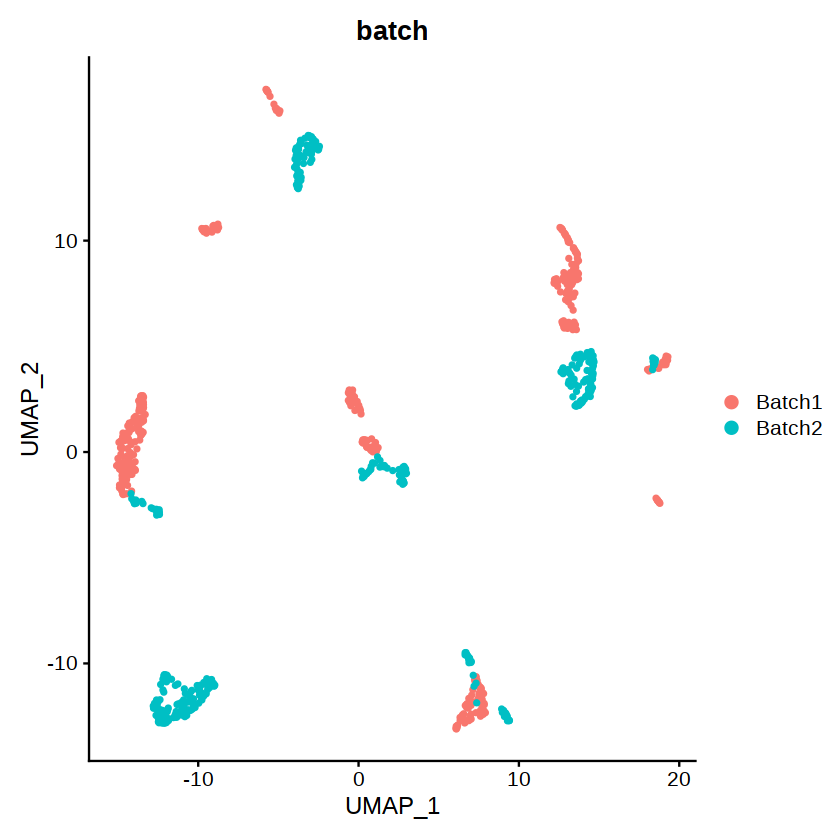

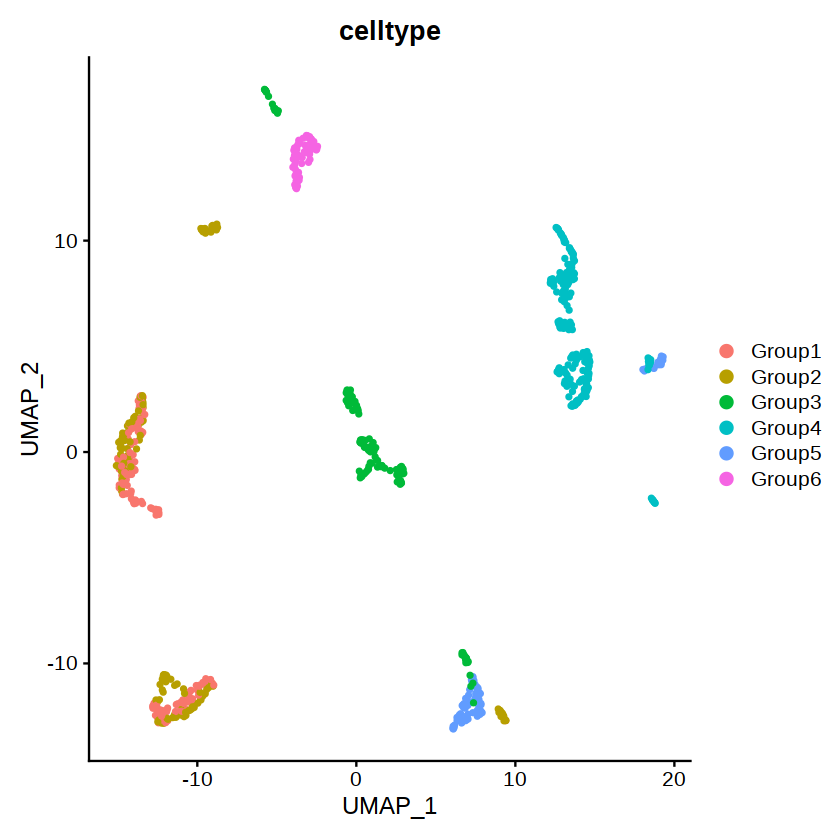

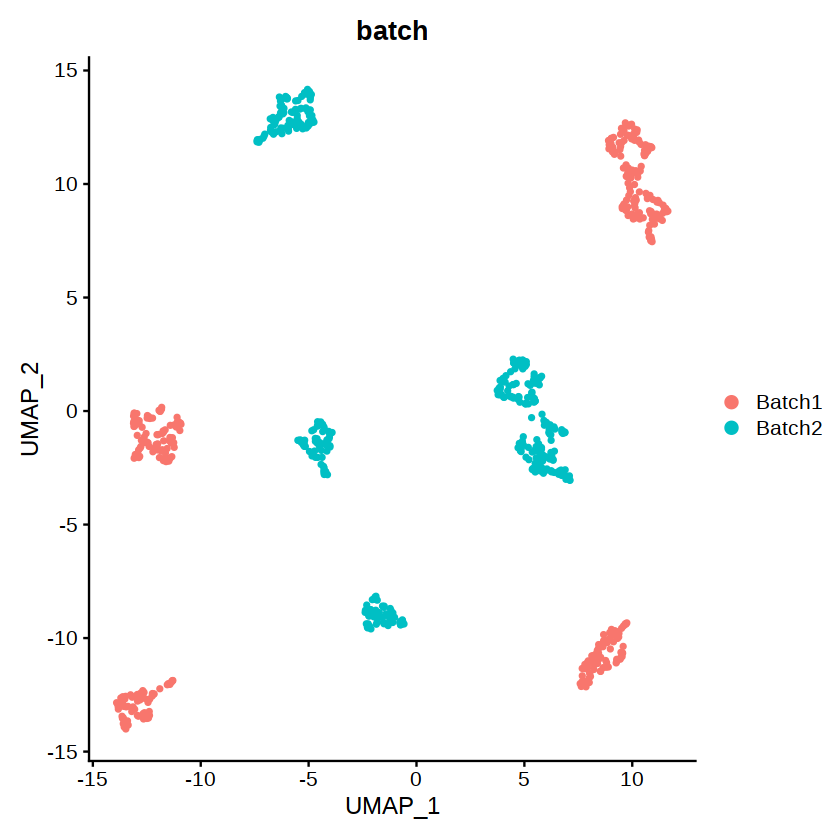

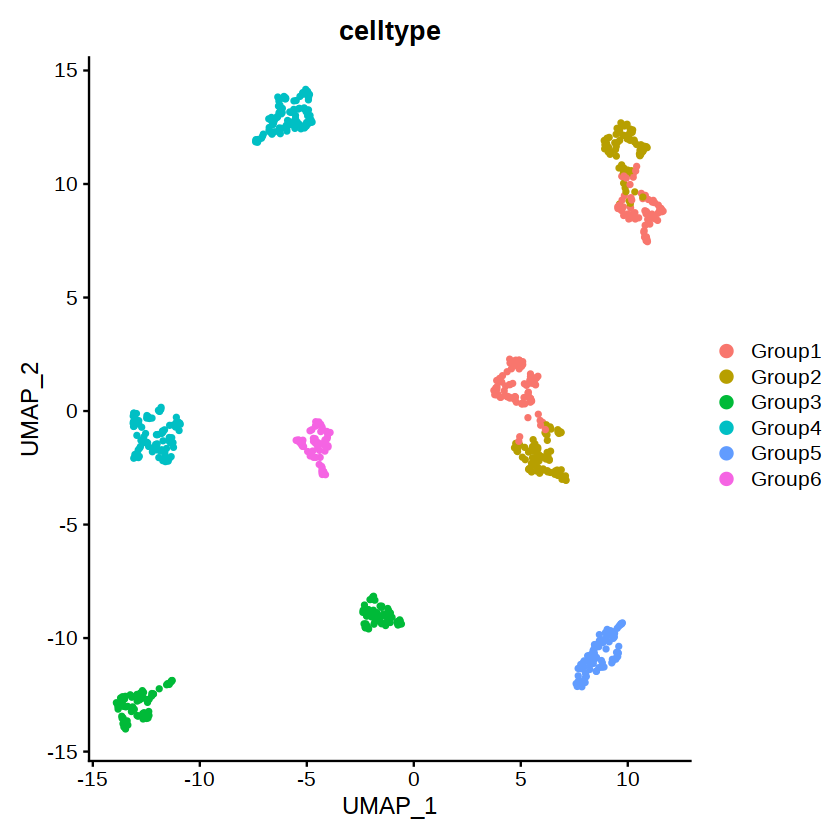

In [19]:
DimPlot(obj.inte2,group.by="batch")
DimPlot(obj.inte2,group.by="celltype")
DimPlot(obj.inte3,group.by="batch")
DimPlot(obj.inte3,group.by="celltype")

模拟空间位置: type1

In [31]:
# ############################################
# cells=colnames(mat)
# ub=unique(meta$batch)
# posi<-function(BID){
#     X=range(0,10)
#     Y=range(0,10)
#     cell_1=cells[meta$batch==ub[BID]]
#     celltype_1=meta$celltype[meta$batch==ub[BID]]
#     celltype_1=factor(celltype_1,levels=c('Group1','Group2','Group3','Group4','Group5','Group6'))
#     uc1=levels(celltype_1)
#     ################################
#     id=1
#     cell1=cell_1[celltype_1==uc1[id]]
#     cell1=sample(cell1,length(cell1),replace=F)
#     n=length(cell1)%/%3*2
#     X1=runif(n, min=5, max=7)
#     Y1=runif(n, min=0, max=3)
#     X2=runif(length(cell1)-n, min=7, max=9)
#     Y2=runif(length(cell1)-n,min=0,max=(9-X2))
#     data1=data.frame(x=c(X1,X2),y=c(Y1,Y2),celltype=uc1[id],batch=ub[BID])
#     rownames(data1)<-cell1

#     id=2
#     cell1=cell_1[celltype_1==uc1[id]]
#     cell1=sample(cell1,length(cell1),replace=F)
#     X1=runif(length(cell1), min=5, max=9)
#     Y1=runif(length(cell1), min=5, max=10)
#     data2=data.frame(x=X1,y=Y1,celltype=uc1[id],batch=ub[BID])
#     rownames(data2)<-cell1

#     id=3
#     cell1=cell_1[celltype_1==uc1[id]]
#     cell1=sample(cell1,length(cell1),replace=F)
#     X1=runif(length(cell1), min=0, max=5)
#     Y1=runif(length(cell1), min=0, max=5)
#     data3=data.frame(x=X1,y=Y1,celltype=uc1[id],batch=ub[BID])
#     rownames(data3)<-cell1

#     id=4
#     cell1=cell_1[celltype_1==uc1[id]]
#     cell1=sample(cell1,length(cell1),replace=F)
#     X1=runif(length(cell1), min=0, max=5)
#     Y1=runif(length(cell1), min=5, max=10)
#     data4=data.frame(x=X1,y=Y1,celltype=uc1[id],batch=ub[BID])
#     rownames(data4)<-cell1

#     id=5
#     cell1=cell_1[celltype_1==uc1[id]]
#     cell1=sample(cell1,length(cell1),replace=F)
#     X1=runif(length(cell1), min=5, max=7)
#     Y1=runif(length(cell1), min=3, max=5)
#     data5=data.frame(x=X1,y=Y1,celltype=uc1[id],batch=ub[BID])
#     rownames(data5)<-cell1

#     id=6
#     cell1=cell_1[celltype_1==uc1[id]]
#     cell1=sample(cell1,length(cell1),replace=F)
#     n=length(cell1)%/%3*2
#     X1=runif(n, min=7, max=9)
#     Y1=runif(n, min=3, max=5)
#     X2=runif(length(cell1)-n, min=7, max=9)
#     Y2=runif(length(cell1)-n,min=(9-X2),max=3)
#     data6=data.frame(x=c(X1,X2),y=c(Y1,Y2),celltype=uc1[id],batch=ub[BID])
#     rownames(data6)<-cell1
#     data_1=rbind(data1,rbind(data2,rbind(data3,rbind(data4,rbind(data5,data6)))))
#     return(data_1)
# }
# data_1=posi(1)
# data_2=posi(2)
# data=rbind(data_1,data_2)
# ggplot(data,aes(x,y,color=celltype,shape=batch))+geom_point()
# write.table(data,paste(dirs,"spatial_posi_",batch_sim,".txt",sep=""),row.names=T,col.names=T,quote=F,sep=',')

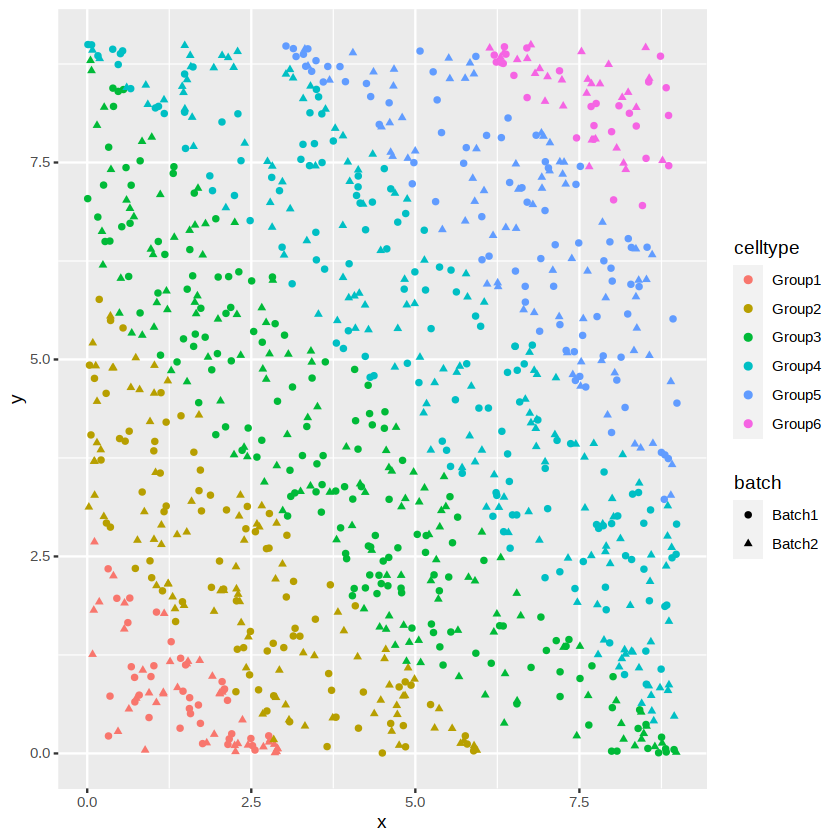

In [32]:
ggplot(data,aes(x,y,color=celltype,shape=batch))+geom_point()
# ggplot(posi,aes(x,y,color=spaMNN_anchor))+geom_point()

模拟空间位置: type2,types3,types4

In [5]:
batch_sim="_1"
types="_types4"
mat<-readMM(paste(dirs,"origin/mat",batch_sim,types,".mtx",sep=""))
rownames(mat)<-read.table(paste(dirs,"origin/mat_rownames",batch_sim,types,".txt",sep=""))[,1]
colnames(mat)<-read.table(paste(dirs,"origin/mat_colnames",batch_sim,types,".txt",sep=""))[,1]
meta<-read.table(paste(dirs,"origin/meta",batch_sim,types,".txt",sep=""),header=T,row.names=1,sep=',',stringsAsFactors=F)

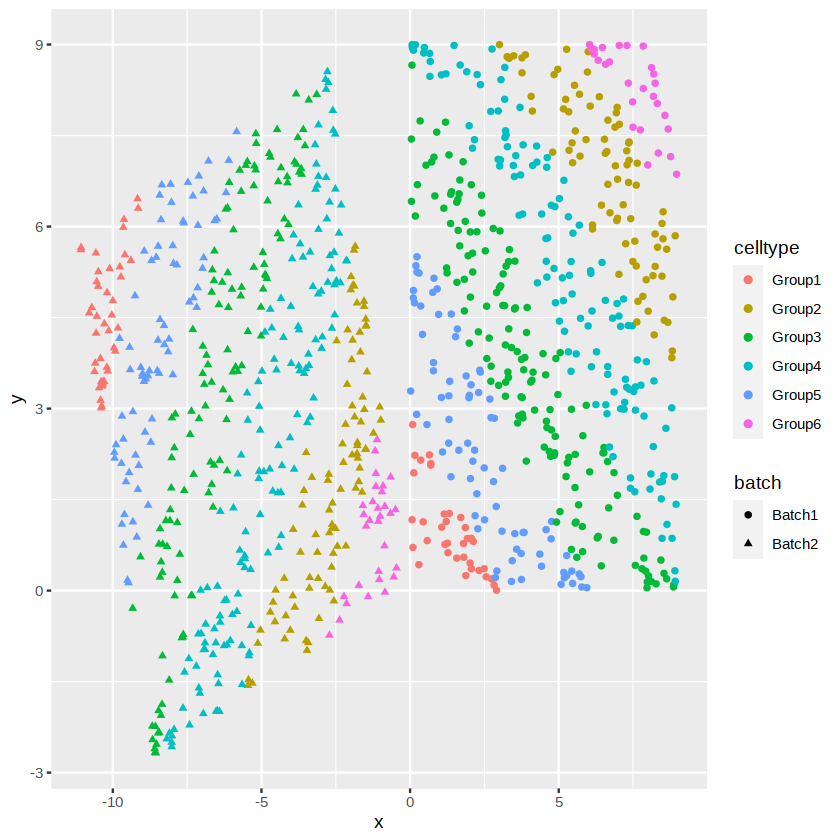

In [25]:
############################################
cells=colnames(mat)
ub=unique(meta$batch)
posi<-function(BID,cell_levels){
    X=range(0,9)
    Y=range(0,9)
    cell_1=cells[meta$batch==ub[BID]]
    celltype_1=meta$celltype[meta$batch==ub[BID]]
    celltype_1=factor(celltype_1,levels=cell_levels)
    uc1=levels(celltype_1)
    ################################
    id=1
    cell1=cell_1[celltype_1==uc1[id]]
    cell1=sample(cell1,length(cell1),replace=F)
    X1=runif(length(cell1), min=0, max=3)
    Y1=runif(length(cell1), min=0, max=3-X1)
    data1=data.frame(x=X1,y=Y1,celltype=uc1[id],batch=ub[BID])
    rownames(data1)<-cell1

    id=2
    cell1=cell_1[celltype_1==uc1[id]]
    cell1=sample(cell1,length(cell1),replace=F)
    n=length(cell1)%/%3
    X1=runif(n, min=3, max=6)
    Y1=runif(n, min=0, max=6-X1)
    X2=runif(length(cell1)-n,min=0, max=3)
    Y2=runif(length(cell1)-n,min=3-X2,max=6-X2)
    data2=data.frame(x=c(X1,X2),y=c(Y1,Y2),celltype=uc1[id],batch=ub[BID])
    rownames(data2)<-cell1

    id=3
    cell1=cell_1[celltype_1==uc1[id]]
    cell1=sample(cell1,length(cell1),replace=F)
    n=length(cell1)%/%5
    X1=runif(n, min=6, max=9)
    Y1=runif(n, min=0, max=9-X1)
    X2=runif(length(cell1)-n,min=0, max=6)
    Y2=runif(length(cell1)-n,min=6-X2,max=9-X2)
    data3=data.frame(x=c(X1,X2),y=c(Y1,Y2),celltype=uc1[id],batch=ub[BID])
    rownames(data3)<-cell1

    id=4
    cell1=cell_1[celltype_1==uc1[id]]
    cell1=sample(cell1,length(cell1),replace=F)
    n=length(cell1)%/%5
    X1=runif(n, min=0, max=3)
    Y1=runif(n, min=9-X1, max=9)
    X2=runif(length(cell1)-n,min=3, max=9)
    Y2=runif(length(cell1)-n,min=9-X2,max=12-X2)
    data4=data.frame(x=c(X1,X2),y=c(Y1,Y2),celltype=uc1[id],batch=ub[BID])
    rownames(data4)<-cell1

    id=5
    cell1=cell_1[celltype_1==uc1[id]]
    cell1=sample(cell1,length(cell1),replace=F)
    n=length(cell1)%/%3
    X1=runif(n, min=3, max=6)
    Y1=runif(n, min=12-X1, max=9)
    X2=runif(length(cell1)-n,min=6, max=9)
    Y2=runif(length(cell1)-n,min=12-X2,max=15-X2)
    data5=data.frame(x=c(X1,X2),y=c(Y1,Y2),celltype=uc1[id],batch=ub[BID])
    rownames(data5)<-cell1

    id=6
    cell1=cell_1[celltype_1==uc1[id]]
    cell1=sample(cell1,length(cell1),replace=F)
    X1=runif(length(cell1), min=6, max=9)
    Y1=runif(length(cell1), min=15-X1, max=9)
    data6=data.frame(x=X1,y=Y1,celltype=uc1[id],batch=ub[BID])
    rownames(data6)<-cell1
    data_1=rbind(data1,rbind(data2,rbind(data3,rbind(data4,rbind(data5,data6)))))
    return(data_1)
}
data_1=posi(1,c('Group1','Group5','Group3','Group4','Group2','Group6'))
data_2=posi(2,c('Group6','Group2','Group4','Group3','Group5','Group1'))
angle=0.6*pi
R=matrix(c(cos(angle),sin(angle),-sin(angle),cos(angle)),ncol=2,nrow=2)
data_2[,1:2]=t(R%*%t(as.matrix(data_2[,1:2])))
data=rbind(data_1,data_2)
ggplot(data,aes(x,y,color=celltype,shape=batch))+geom_point()
write.table(data,paste(dirs,"origin/spatial_posi",batch_sim,types,".txt",sep=""),row.names=T,col.names=T,quote=F,sep=',')

模拟空间位置: type5

In [87]:
batch_sim="_1"
types="_types5"
mat<-readMM(paste(dirs,"origin/mat",batch_sim,types,".mtx",sep=""))
rownames(mat)<-read.table(paste(dirs,"origin/mat_rownames",batch_sim,types,".txt",sep=""))[,1]
colnames(mat)<-read.table(paste(dirs,"origin/mat_colnames",batch_sim,types,".txt",sep=""))[,1]
meta<-read.table(paste(dirs,"origin/meta",batch_sim,types,".txt",sep=""),header=T,row.names=1,sep=',',stringsAsFactors=F)

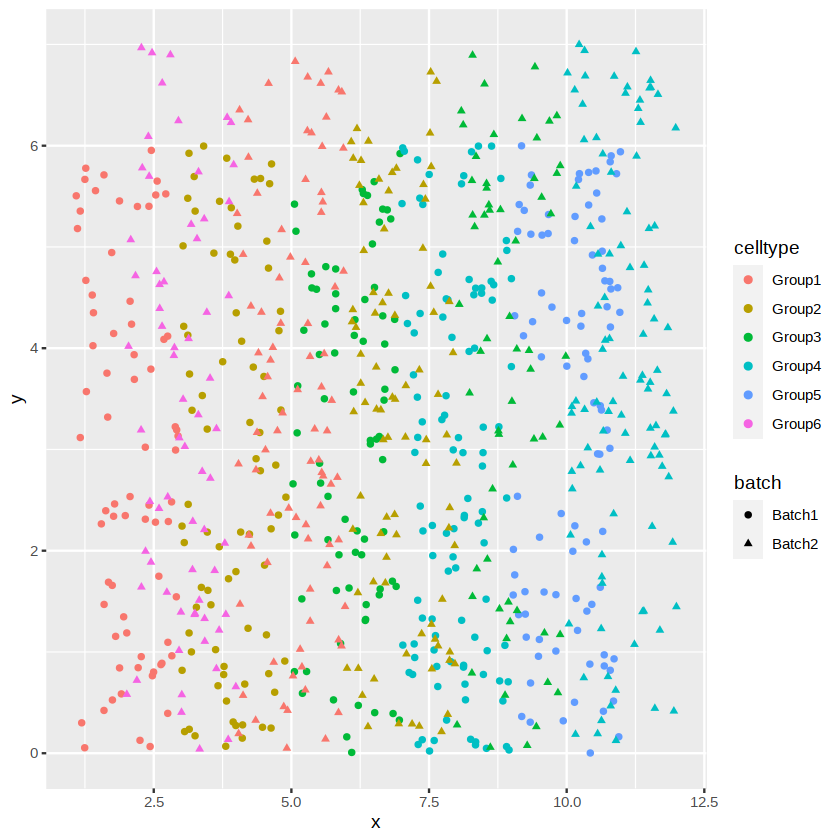

In [88]:
############################################
cells=colnames(mat)
ub=unique(meta$batch)
posi<-function(BID,cell_levels){
    
    cell_1=cells[meta$batch==ub[BID]]
    celltype_1=meta$celltype[meta$batch==ub[BID]]
    celltype_1=factor(celltype_1,levels=cell_levels)
    uc1=levels(celltype_1)
    X=seq(0,10,10/(length(uc1)))+BID
    Y=5+BID
    data1=data.frame(x=0,y=0,celltype=0,batch=0)
    for(id in 1:length(uc1)){
        cell1=cell_1[celltype_1==uc1[id]]
        cell1=sample(cell1,length(cell1),replace=F)
        X1=runif(length(cell1), min=X[id], max=X[id+1])
        Y1=runif(length(cell1), min=0, max=Y)
        a=data.frame(x=X1,y=Y1,celltype=uc1[id],batch=ub[BID])
        rownames(a)<-cell1
        data1=rbind(data1,a)
    }
    data1=data1[-1,]
    return(data1)
}
data_1=posi(1,c('Group1','Group2','Group3','Group4','Group5'))
data_2=posi(2,c('Group6','Group1','Group2','Group3','Group4'))
data=rbind(data_1,data_2)
ggplot(data,aes(x,y,color=celltype,shape=batch))+geom_point()
write.table(data,paste(dirs,"origin/spatial_posi",batch_sim,types,".txt",sep=""),row.names=T,col.names=T,quote=F,sep=',')

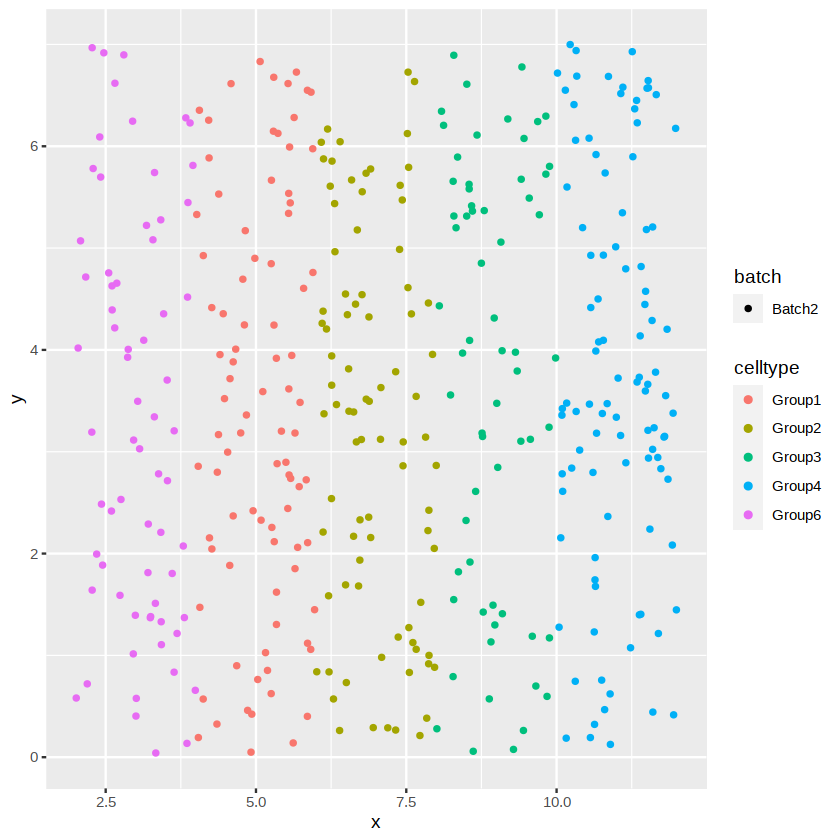

In [90]:
ggplot(data_2,aes(x,y,color=celltype,shape=batch))+geom_point()

模拟空间位置：types6

In [ ]:
batch_sim="_1"
types="_types6"
mat<-readMM(paste(dirs,"origin/mat",batch_sim,types,".mtx",sep=""))
rownames(mat)<-read.table(paste(dirs,"origin/mat_rownames",batch_sim,types,".txt",sep=""))[,1]
colnames(mat)<-read.table(paste(dirs,"origin/mat_colnames",batch_sim,types,".txt",sep=""))[,1]
meta<-read.table(paste(dirs,"origin/meta",batch_sim,types,".txt",sep=""),header=T,row.names=1,sep=',',stringsAsFactors=F)

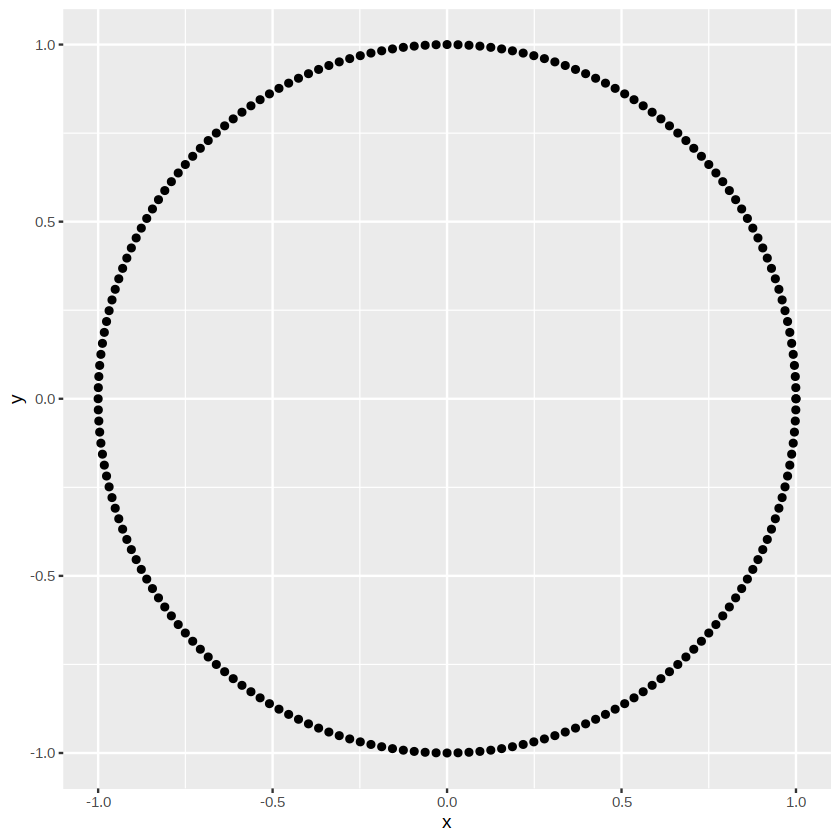

In [99]:
theta=seq(0,2*pi,0.01*pi)
X=cos(theta)
Y=sin(theta)
data=data.frame(x=X,y=Y)
ggplot(data,aes(x,y))+geom_point()

下游分析

In [4]:
library(splatter)

library(scater)
library(Seurat)
library(dplyr)
library(Matrix)
# library(clues)
# library(SC3)
library(SingleCellExperiment)
library(harmony)
library(FNN)
library(flexclust)
library(stats)
library(aricode)
dirs="/data02/tguo/space_batch_effect/simulate/"


Attaching package: ‘aricode’


The following object is masked from ‘package:FNN’:

    entropy




In [103]:
batch_sim="_1_2"
types="_3batch_types5"
flags=paste(batch_sim,types,sep='')
count=read.csv(paste(dirs,"gtt_input/feat1",flags,".csv",sep=""),header=T,row.names=1)
meta=read.table(paste(dirs,"gtt_input/meta1",flags,".csv",sep=""),header=T,row.names=1,sep=',')
coord=read.table(paste(dirs,"gtt_input/coord1",flags,".csv",sep=""),header=T,row.names=1,sep=',')
B=3
for(i in 2:B){
    count=rbind(count,read.csv(paste(dirs,"gtt_input/feat",i,flags,".csv",sep=""),header=T,row.names=1))
    meta=rbind(meta,read.table(paste(dirs,"gtt_input/meta",i,flags,".csv",sep=""),header=T,row.names=1,sep=','))
    coord=rbind(coord,read.table(paste(dirs,"gtt_input/coord",i,flags,".csv",sep=""),header=T,row.names=1,sep=','))
}
count=as(as.matrix(t(count)),'dgCMatrix')
meta=meta[colnames(count),]
coord=coord[colnames(count),]

obj<-CreateSeuratObject(counts=count,min.cells=0, min.features=0,meta.data=meta)
VariableFeatures(obj)<-rownames(obj)
obj@assays$RNA@scale.data=as.matrix(count)
# obj<-ScaleData(obj)
# obj<-RunPCA(obj,npcs=50)
# obj<-RunUMAP(obj,reduction='pca',dims=1:50)
obj@images$image <- new(
    Class = 'SlideSeq',
    assay = "Spatial",
    key = "image_",
    coordinates = coord
 )

In [104]:
embed1=read.csv(paste(dirs,"gtt_output/AGC_embed",flags,"_xent.csv",sep=""),header=T,row.names=1)
if(dim(embed1)[2]==16){
    znoise_dim=3}else{
    znoise_dim=5
}
embed1=embed1[colnames(count),znoise_dim:dim(embed1)[2]]
obj[['GTT']]<-CreateDimReducObject(embeddings=as.matrix(embed1), key = "GTT_", assay = DefaultAssay(obj))
obj <-RunUMAP(obj, reduction = "GTT",dims=1:dim(embed1)[2],reduction.name="GTT.umap")
embed2=read.csv(paste(dirs,"methods/seurat_mat",flags,".txt",sep=""),header=T,row.names=1)
embed2=embed2[colnames(count),]
obj[['Seurat']]<-CreateDimReducObject(embeddings=as.matrix(embed2), key = "Seurat_", assay = DefaultAssay(obj))
embed3=read.csv(paste(dirs,"methods/harmony_mat",flags,".txt",sep=""),header=T,row.names=1)
embed3=embed3[colnames(count),]
obj[['Harmony']]<-CreateDimReducObject(embeddings=as.matrix(embed3), key = "Harmony_", assay = DefaultAssay(obj))
embed4=read.csv(paste(dirs,"methods/harmony_SEDR_mat",flags,".txt",sep=""),header=T,row.names=1)
embed4=embed4[colnames(count),]
obj[['SEDR']]<-CreateDimReducObject(embeddings=as.matrix(embed4), key = "SEDR_", assay = DefaultAssay(obj))
embed5=read.csv(paste(dirs,"methods/harmony_STAGATE_mat",flags,".txt",sep=""),header=T,row.names=1)
embed5=embed5[colnames(count),]
obj[['STAGATE']]<-CreateDimReducObject(embeddings=as.matrix(embed5), key = "STAGATE_", assay = DefaultAssay(obj))

obj <-RunUMAP(obj, reduction = "Seurat",dims=1:dim(embed2)[2],reduction.name="Seurat.umap")
obj <-RunUMAP(obj, reduction = "Harmony",dims=1:dim(embed3)[2],reduction.name="Harmony.umap")
obj <-RunUMAP(obj, reduction = "SEDR",dims=1:dim(embed4)[2],reduction.name="SEDR.umap")
obj <-RunUMAP(obj, reduction = "STAGATE",dims=1:dim(embed5)[2],reduction.name="STAGATE.umap")


16:49:11 UMAP embedding parameters a = 0.9922 b = 1.112

16:49:11 Read 846 rows and found 28 numeric columns

16:49:11 Using Annoy for neighbor search, n_neighbors = 30

16:49:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:49:11 Writing NN index file to temp file /tmp/RtmpEKZvBi/file173017d07a01

16:49:11 Searching Annoy index using 1 thread, search_k = 3000

16:49:11 Annoy recall = 100%

16:49:12 Commencing smooth kNN distance calibration using 1 thread

16:49:14 Found 6 connected components, 
falling back to 'spca' initialization with init_sdev = 1

16:49:14 Initializing from PCA

16:49:14 PCA: 2 components explained 64.93% variance

16:49:14 Commencing optimization for 500 epochs, with 34838 positive edges

16:49:18 Optimization finished

16:49:18 UMAP embedd

In [105]:
res=c(0.5,0.5,0.5,0.15,0.1)
res=c(0.3,0.55,0.55,0.1,0.1)
res=c(0.2,0.5,0.7,0.1,0.1)
res=c(0.8,0.5,0.5,0.05,0.05)
res=c(0.5,0.5,0.5,0.05,0.05)


obj<-FindNeighbors(obj, dims=1:dim(embed1)[2],reduction="GTT")
obj<-FindClusters(obj, resolution =res[1])
obj$gtt=obj$seurat_clusters
length(unique(obj$gtt))

obj<-FindNeighbors(obj, dims=1:dim(embed2)[2],reduction="Seurat")
obj<-FindClusters(obj, resolution = res[2])
obj$seurat=obj$seurat_clusters
length(unique(obj$seurat))

obj<-FindNeighbors(obj, dims=1:dim(embed3)[2],reduction="Harmony")
obj<-FindClusters(obj, resolution = res[3])
obj$harmony=obj$seurat_clusters
length(unique(obj$harmony))

obj<-FindNeighbors(obj, dims=1:dim(embed4)[2],reduction="SEDR")
obj<-FindClusters(obj, resolution =res[4])
obj$sedr=obj$seurat_clusters
length(unique(obj$sedr))


obj<-FindNeighbors(obj, dims=1:dim(embed5)[2],reduction="STAGATE")
obj<-FindClusters(obj, resolution =res[5])
obj$stagate=obj$seurat_clusters
length(unique(obj$stagate))

write.csv(as.data.frame(obj$gtt),paste(dirs,'metrics/louvain_clust',flags,'.csv',sep=""))
write.csv(as.data.frame(obj$seurat),paste(dirs,'metrics/seurat_louvain_clust',flags,'.csv',sep=""))
write.csv(as.data.frame(obj$harmony),paste(dirs,'metrics/harmony_louvain_clust',flags,'.csv',sep=""))
write.csv(as.data.frame(obj$sedr),paste(dirs,'metrics/SEDR_louvain_clust',flags,'.csv',sep=""))
write.csv(as.data.frame(obj$stagate),paste(dirs,'metrics/STAGATE_louvain_clust',flags,'.csv',sep=""))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 846
Number of edges: 42578

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8944
Number of communities: 6
Elapsed time: 0 seconds


[1] 6

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 846
Number of edges: 39386

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8761
Number of communities: 5
Elapsed time: 0 seconds


[1] 5

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 846
Number of edges: 33739

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9054
Number of communities: 7
Elapsed time: 0 seconds


[1] 7

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 846
Number of edges: 17633

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9894
Number of communities: 7
Elapsed time: 0 seconds


[1] 7

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 846
Number of edges: 21821

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9943
Number of communities: 10
Elapsed time: 0 seconds


[1] 10

In [106]:
ari=data.frame(method=c('GraphSCIDRL','seurat','harmony_STAGATE','harmony_SEDR','harmony'),
              ARI_louvain=c(ARI(obj$gtt,obj$celltype),ARI(obj$seurat,obj$celltype),
                            ARI(obj$stagate,obj$celltype),
                            ARI(obj$sedr,obj$celltype),ARI(obj$harmony,obj$celltype)))
write.csv(ari,paste(dirs,'metrics/ARI_louvain',flags,'.csv',sep=""))
ari

method,ARI_louvain
<chr>,<dbl>
GraphSCIDRL,1.0000000
seurat,0.8850923
harmony_STAGATE,0.5864915
harmony_SEDR,0.5450437
harmony,0.9565333


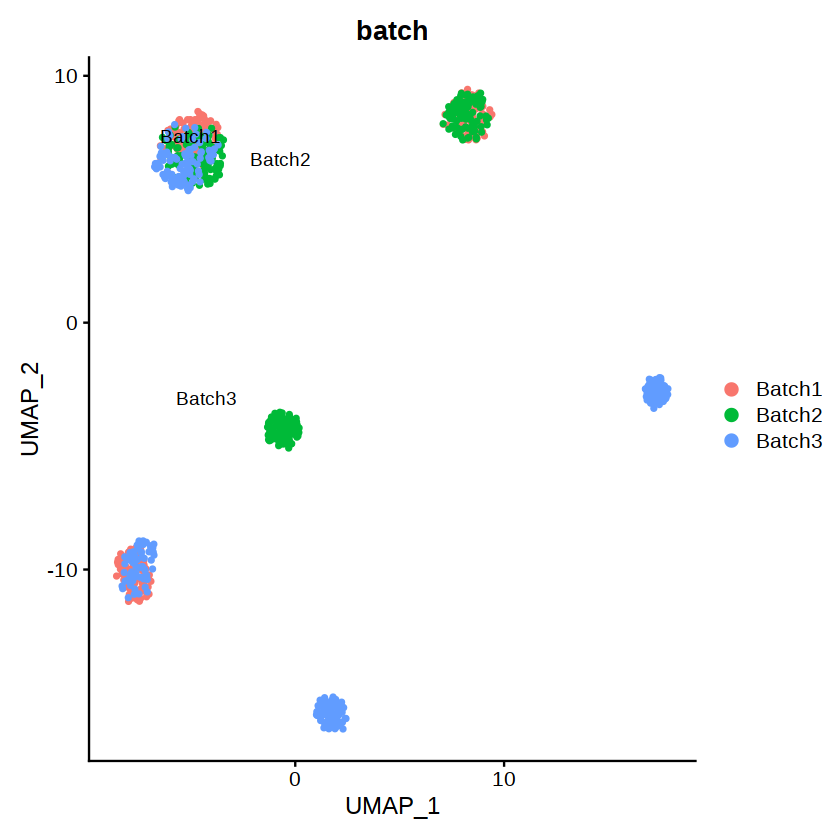

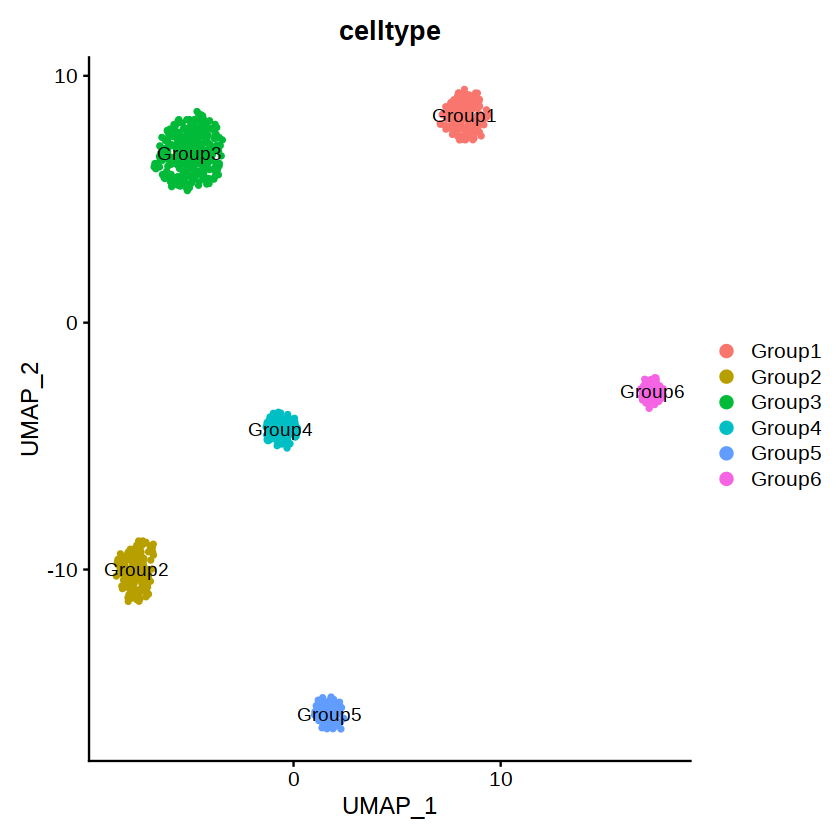

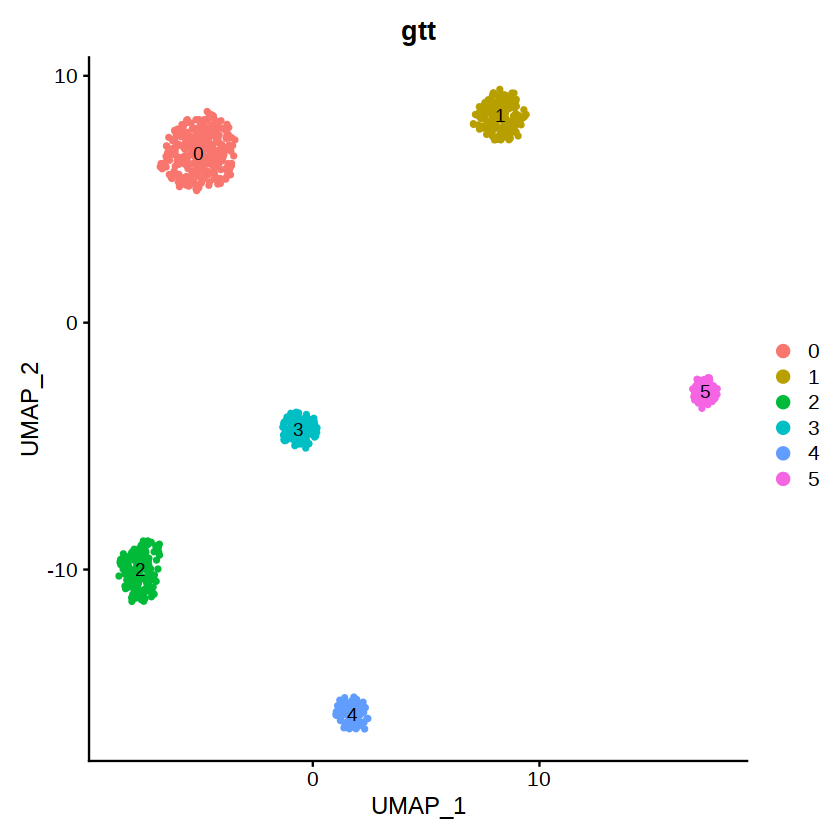

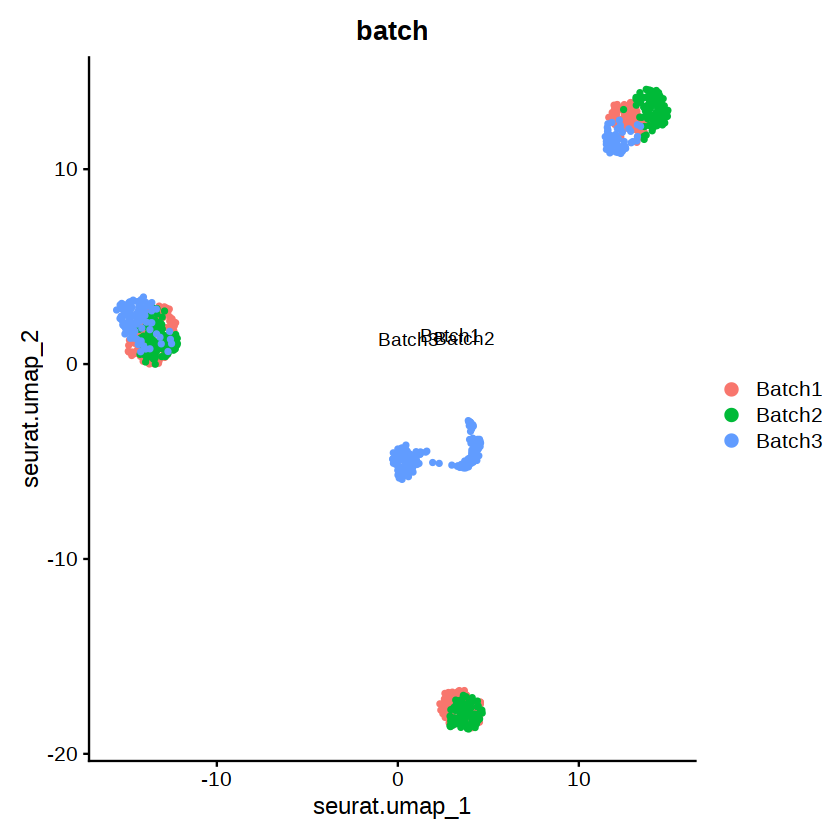

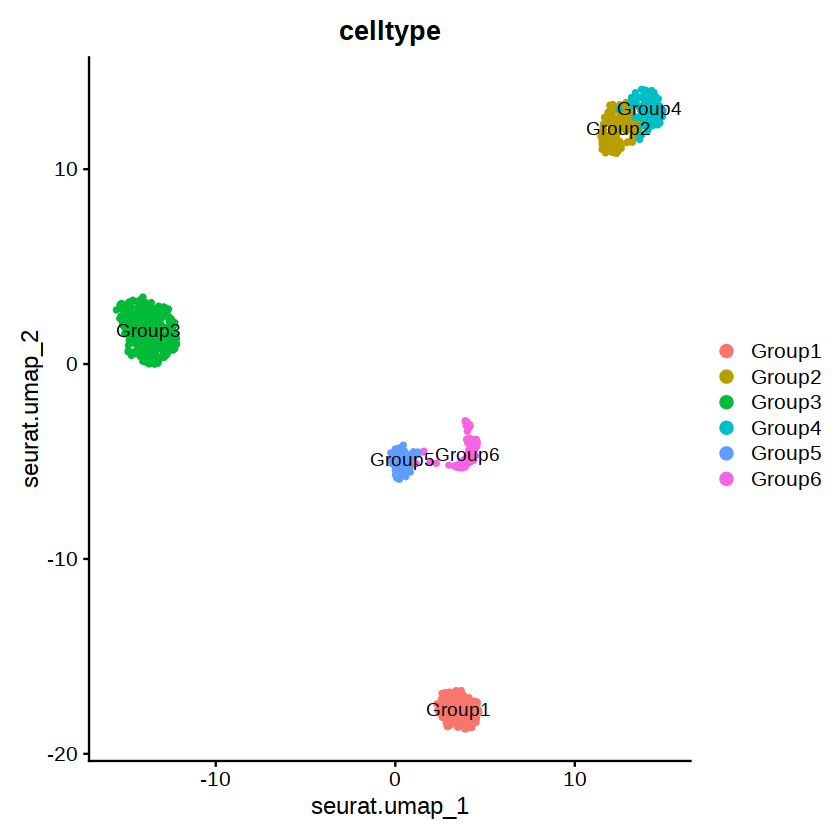

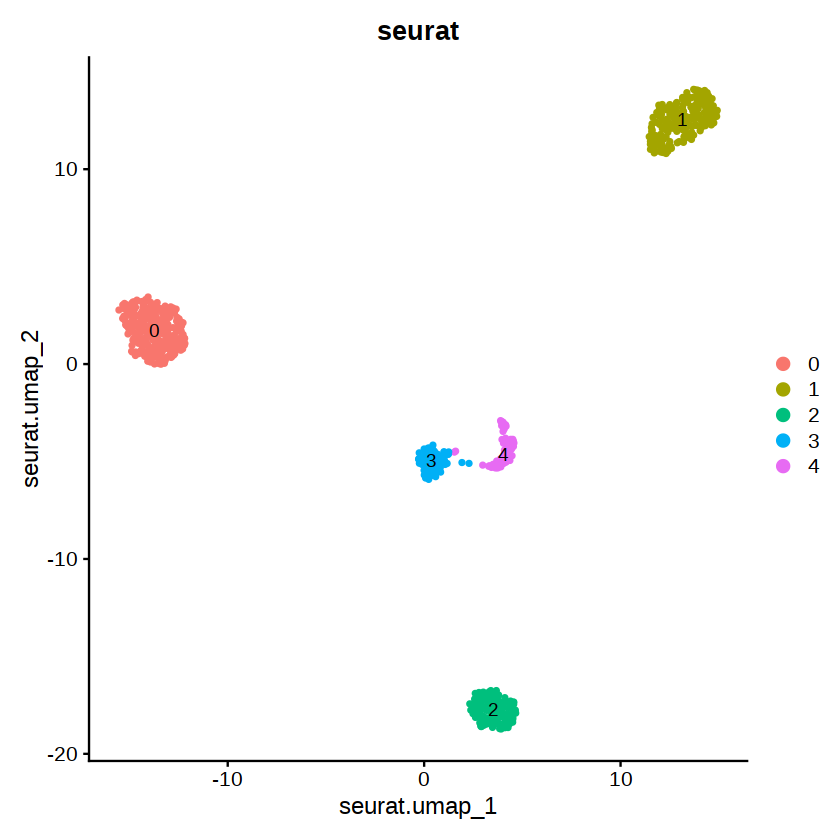

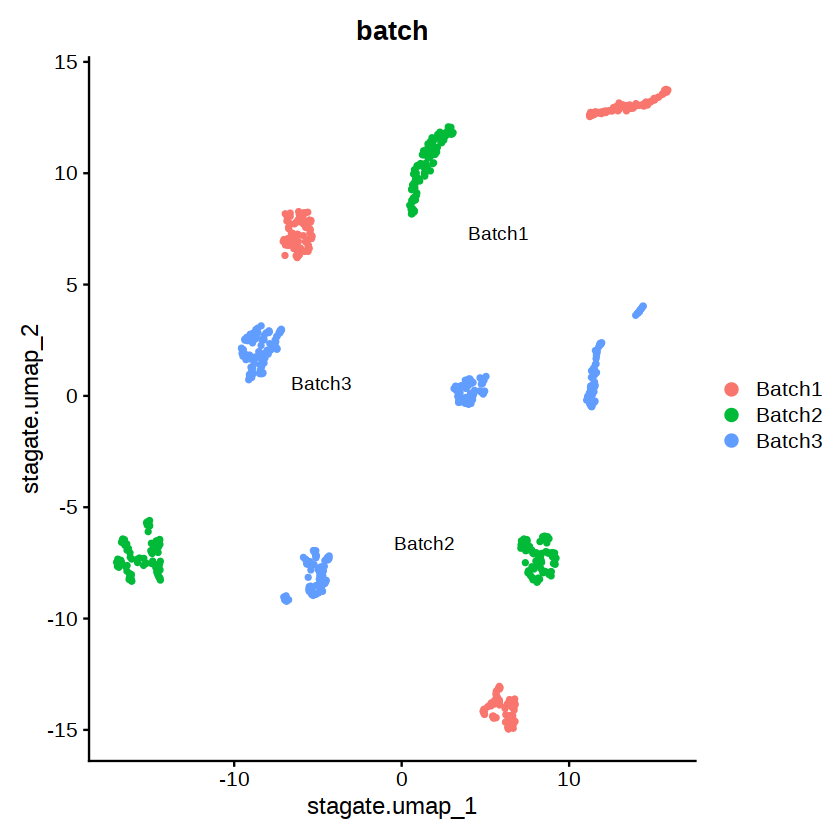

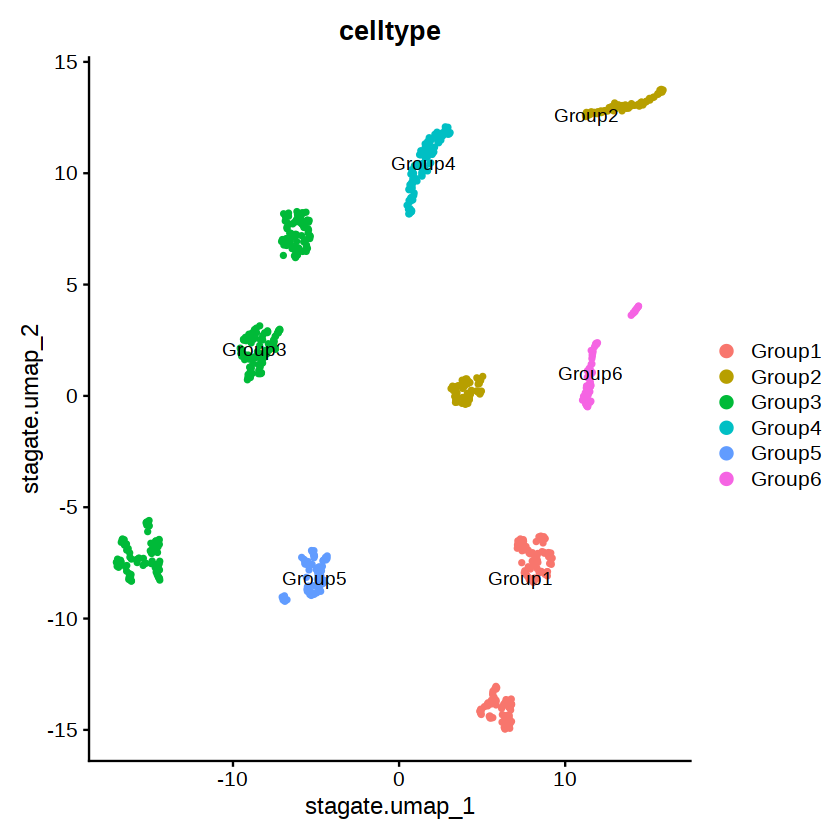

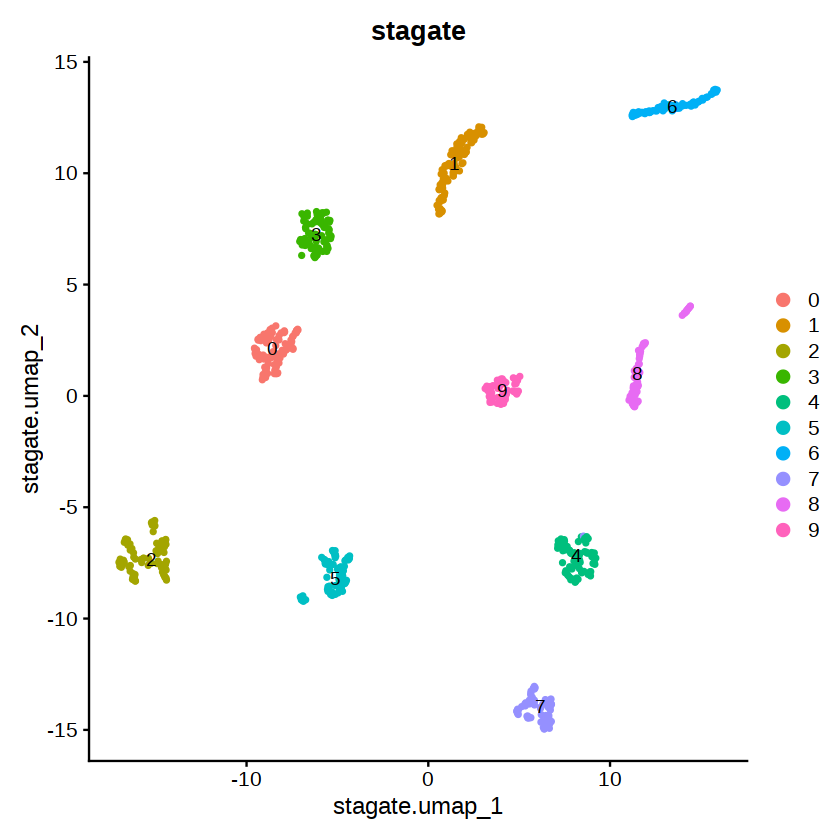

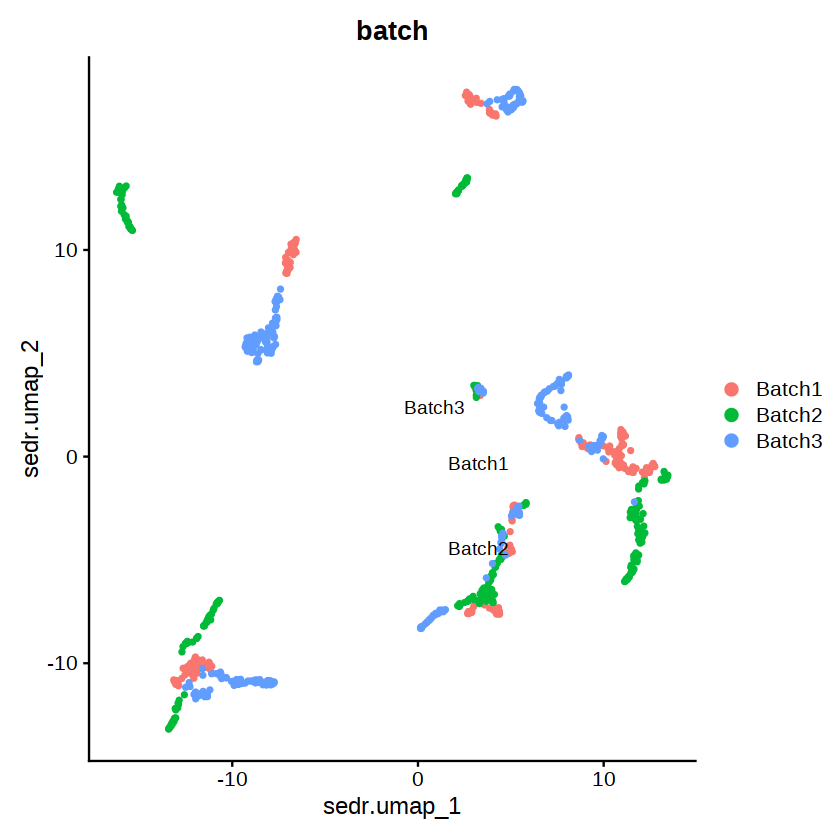

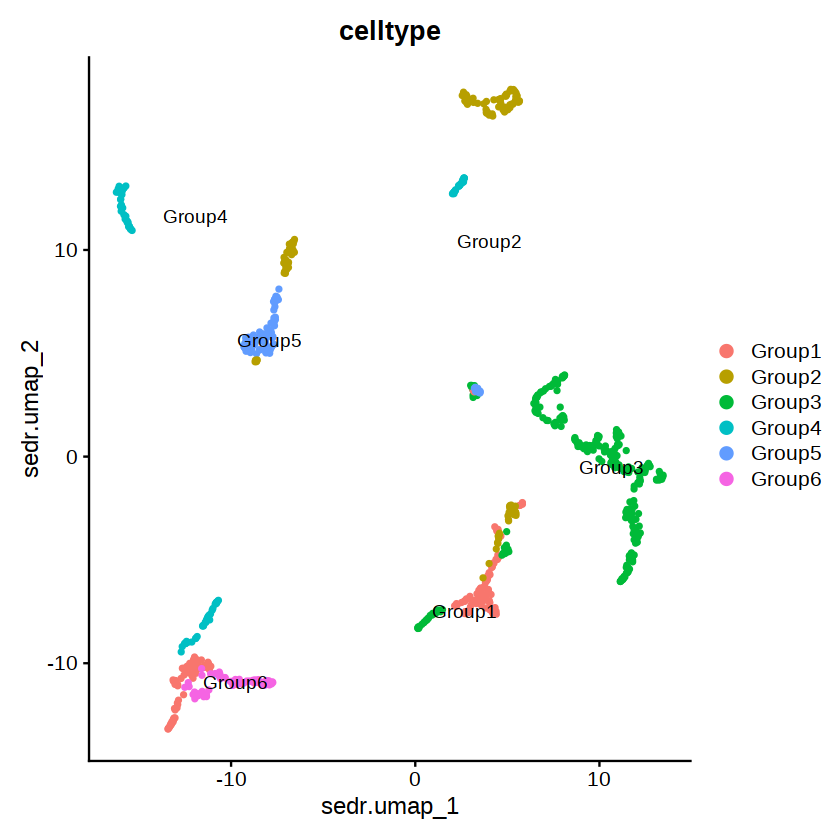

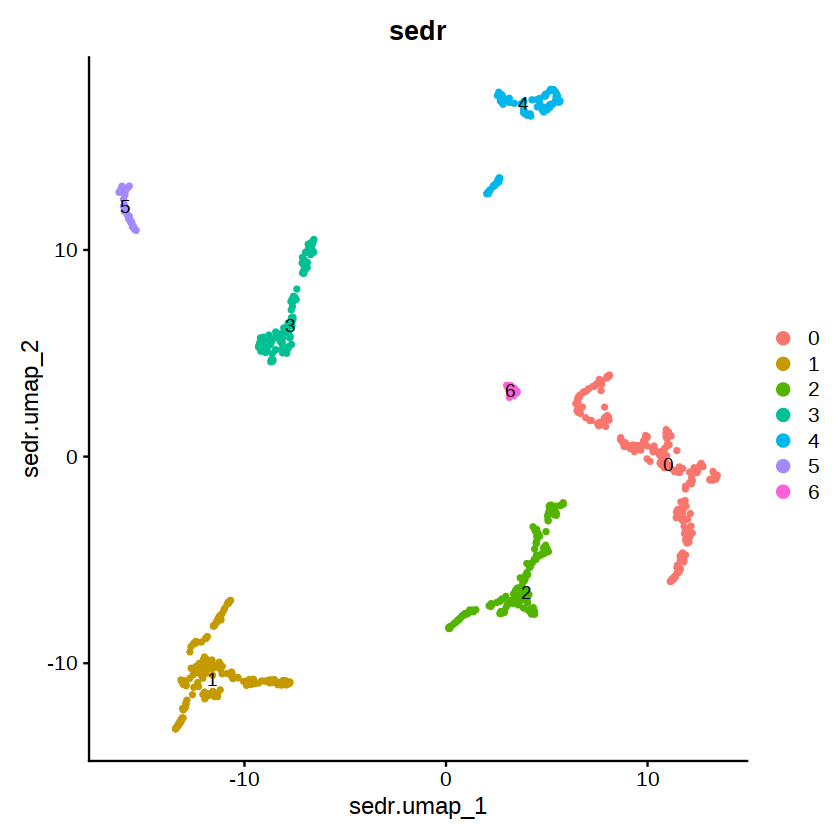

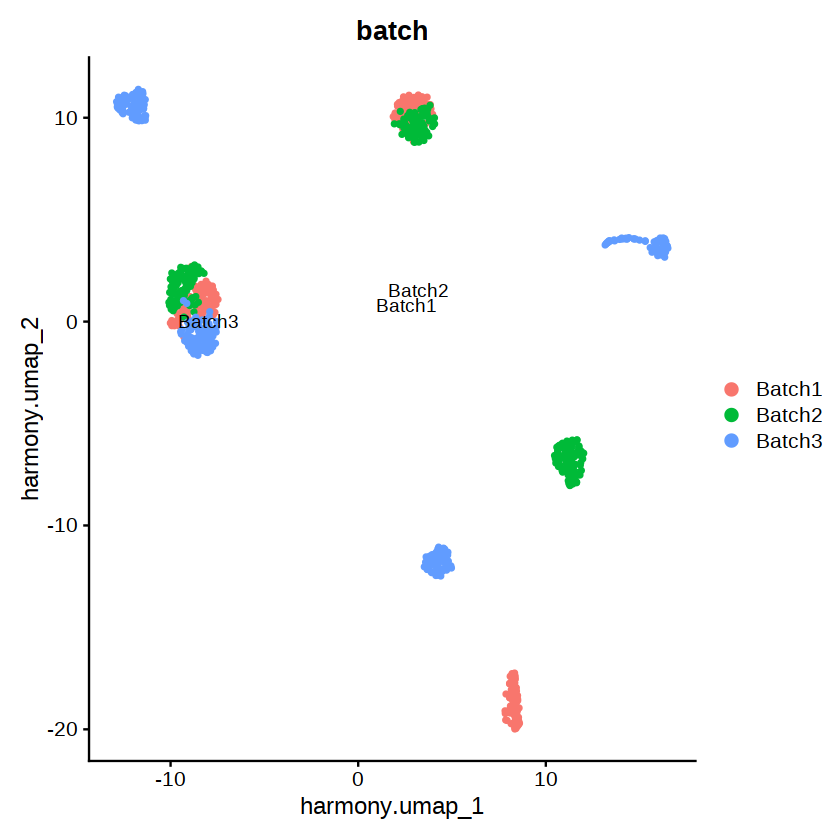

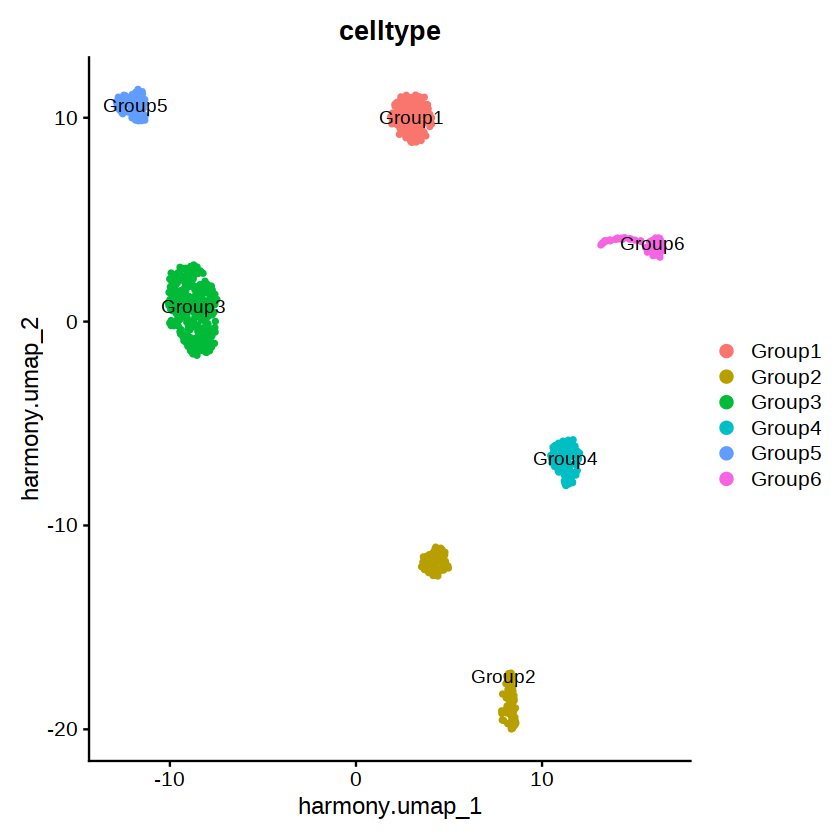

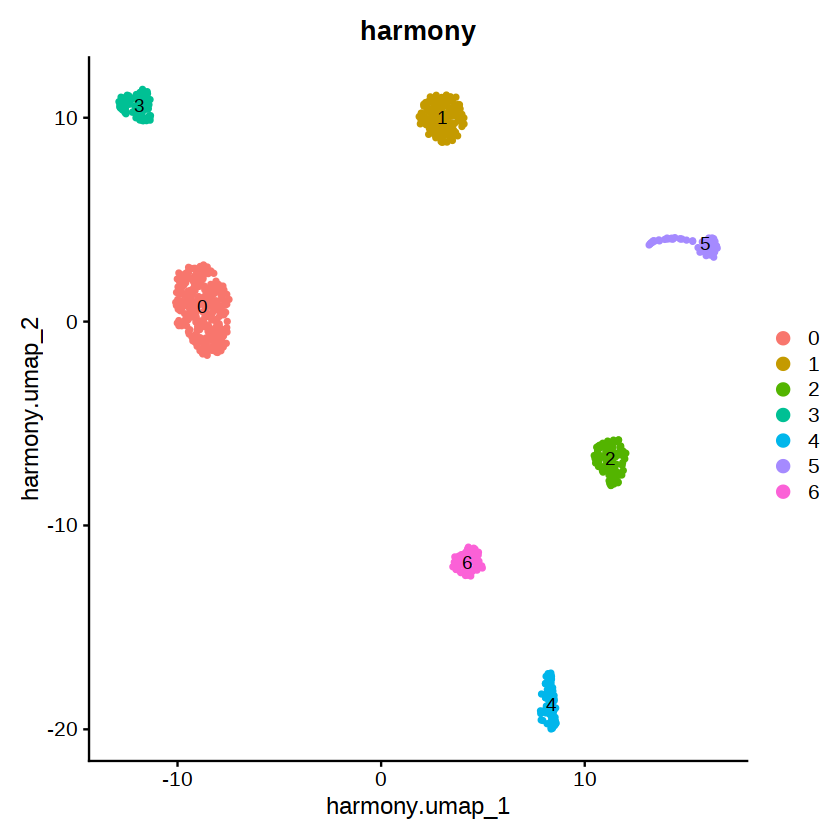

In [108]:
DimPlot(obj,group.by="batch",label=T,reduction='GTT.umap')
DimPlot(obj,group.by="celltype",label=T,reduction='GTT.umap')
DimPlot(obj,group.by="gtt",label=T,reduction='GTT.umap')

DimPlot(obj,group.by="batch",label=T,reduction='Seurat.umap')
DimPlot(obj,group.by="celltype",label=T,reduction='Seurat.umap')
DimPlot(obj,group.by="seurat",label=T,reduction='Seurat.umap')

DimPlot(obj,group.by="batch",label=T,reduction='STAGATE.umap')
DimPlot(obj,group.by="celltype",label=T,reduction='STAGATE.umap')
DimPlot(obj,group.by="stagate",label=T,reduction='STAGATE.umap')

DimPlot(obj,group.by="batch",label=T,reduction='SEDR.umap')
DimPlot(obj,group.by="celltype",label=T,reduction='SEDR.umap')
DimPlot(obj,group.by="sedr",label=T,reduction='SEDR.umap')

DimPlot(obj,group.by="batch",label=T,reduction='Harmony.umap')
DimPlot(obj,group.by="celltype",label=T,reduction='Harmony.umap')
DimPlot(obj,group.by="harmony",label=T,reduction='Harmony.umap')